## Requirements
`pip install tensorflow`
`pip install matlpotlib`

If the code below finds GPU devices, it will run on ine of them, if not the computer's CPU will do the computing.
If program runs slow on your computer, you can try installing CUDA Toolkit https://developer.nvidia.com/cuda-toolkit.

In [12]:
import tensorflow as tf
print("GPUs: ", *tf.config.list_physical_devices('GPU'))

GPUs: 


## Load dependencies, download images and models, define some supporting functions

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import os
import math

images = [
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/bridge-3013297_640.jpg',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/m_content.png',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/puppy-1903313_1280.jpg',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/statue-of-liberty-267948_640.jpg',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/streets-1284394_640.jpg'
]

styles = [
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/m_style.png',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
  'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style4.jpg',
  'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/David-Oath_of_the_Horatii-1784.jpg/1200px-David-Oath_of_the_Horatii-1784.jpg',
  'https://as1.ftcdn.net/v2/jpg/02/26/11/62/1000_F_226116239_STdFBBGq8FIXGOgPf5DmZ0jmiiuXtGWC.jpg'
]

IMAGE_NUM = len(images)
STYLE_NUM = len(styles)


content_paths = [tf.keras.utils.get_file(p[p.rindex('/')+1:], p) for p in images]

style_paths = [tf.keras.utils.get_file(p[p.rindex('/')+1:], p) for p in styles]

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

## Prepare and show test images

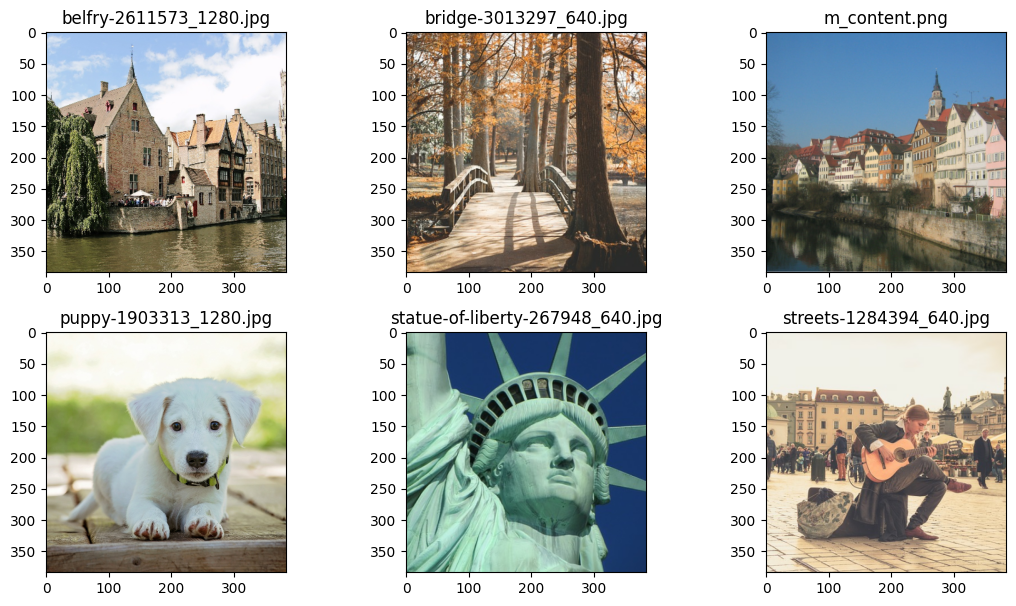

In [14]:
# Load the input images.
content_images = [load_img(i) for i in content_paths]
style_images = [load_img(i) for i in style_paths]

# Preprocess the input images.
preprocessed_content_images = [preprocess_image(i, 384) for i in content_images if i != None]
preprocessed_style_image = [preprocess_image(i, 256) for i in style_images]

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

box_width = 3
box_height = int(math.ceil(IMAGE_NUM / box_width))

plt.subplots_adjust(left=0, bottom=0, right=.8, top=.5, wspace=.5, hspace=0)

for k in range(IMAGE_NUM):
  plt.subplot(box_height, box_width, k + 1)
  imshow(preprocessed_content_images[k], os.path.basename(images[k]))

## Show test style images

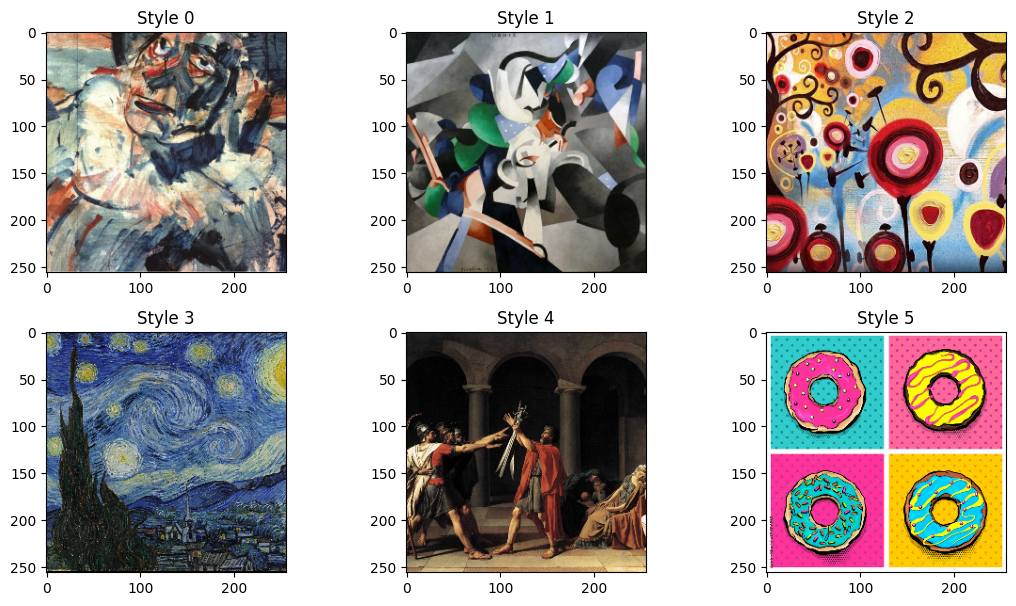

In [15]:
plt.subplots_adjust(left=0, bottom=0, right=.8, top=.5, wspace=.5, hspace=0)

for k in range(STYLE_NUM):
  plt.subplot(box_height, box_width, k + 1)
  imshow(preprocessed_style_image[k], f"Style {k}")

## Predict the style and transform images
- choose favoured style in line 19
- adjust the blending ratio in line 20

Should take a few seconds.

In [16]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"])()

  return style_bottleneck


index = 0  # choose style
content_blending_ratio = 0 # define content blending ratio between [0..1].

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image[index])
print("Style predicted.")
style_bottleneck_content = [run_style_predict(preprocess_image(i, 256)) for i in preprocessed_content_images]
style_bottleneck_blended = [content_blending_ratio * i + (1 - content_blending_ratio) * style_bottleneck for i in style_bottleneck_content]

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_images = [run_style_transform(style_bottleneck_blended[i], preprocessed_content_images[i]) for i in range(IMAGE_NUM)]

print("Images transformed.")

Style predicted.
Images transformed.


## Show tranformed images

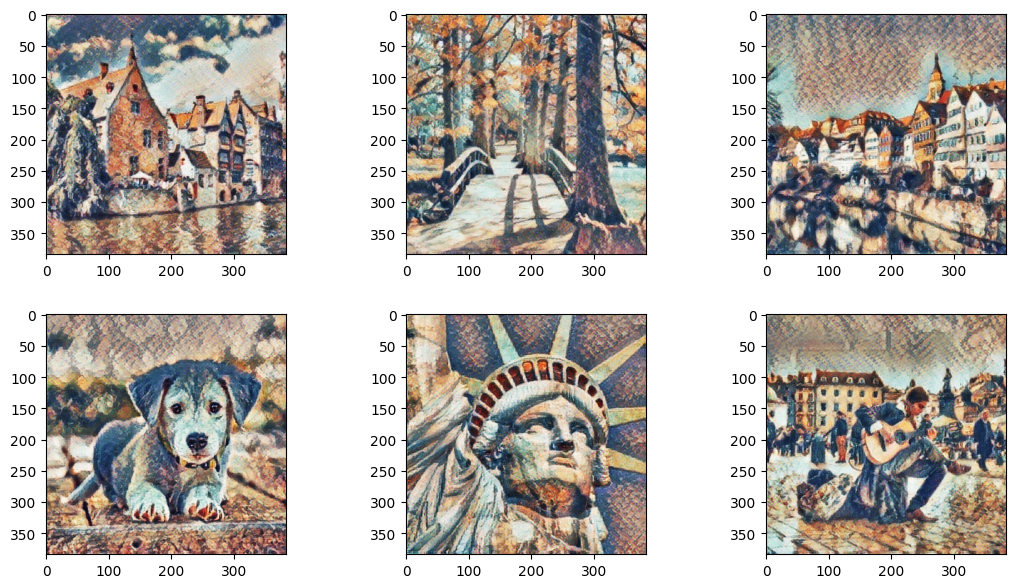

In [17]:
plt.subplots_adjust(left=0, bottom=0, right=.8, top=.5, wspace=.5, hspace=0)

# Visualize the output.
for k in range(IMAGE_NUM):
  plt.subplot(box_height, box_width, k + 1)
  imshow(stylized_images[k])